# Preference Update Bandit

In [1]:
# Import modules.
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import import_ipynb
from abstract_bandit import Bandit

importing Jupyter notebook from abstract_bandit.ipynb


In [2]:
class PrefBandit(Bandit):

    def __init__(self, means, sigmas, arms=10, iters=10000, alpha=None, deterministic=False, stationary=True):
        """Initializes the Upper Confidence Bound bandit."""
        super().__init__(means, sigmas, deterministic=deterministic, stationary=stationary)
        # Step size for update
        self.alpha = alpha
        # Preference values of actions
        self.prefs = np.zeros(arms)
        # Probability of choosing action
        self.probs = np.full(arms, 1. / float(arms))
        # Matrix to store the trend of the preferences
        self.Hs = np.zeros((iters + 1, arms))

    def choose_action(self):
        """Implements the epsilon-greedy policy: exploits knowledge or explores new possibilities."""
        return np.random.choice(list(range(self.arms)), p=self.probs)

    def update_model(self, arm, reward, iteration):
        """Updates estimates and other data after an episode."""
        # Update choice count.
        self.Ns[arm] += 1
        # Update step size.
        if self.alpha == None:
            step_size = 1. / self.Ns[arm]
        else:
            step_size = self.alpha
        # Update preferences.
        for i in range(arms):
            if i == arm:
                self.prefs[i] += step_size * (reward - self.avg_rewards[iteration]) * (1 - self.probs[i])
            else:
                self.prefs[i] -= step_size * (reward - self.avg_rewards[iteration]) * self.probs[i]
        # Update actions probabilities.
        exp_sum = np.sum(np.exp(self.prefs))
        self.probs = np.exp(self.prefs) / exp_sum
        # Eventually increase optimal actions counter.
        if arm == np.argmax(self.means):
            self.opt_actions += 1.0
        # Update real action values.
        if self.stationary == False:
            for i in range(self.arms):
                self.means[i] += np.random.normal()

    def update_sim_data(self, arm , reward, iteration):
        """Updates simulation data after an episode"""
        self.avg_rewards[iteration + 1] = self.avg_rewards[iteration] + (1. / (iteration + 1)) * (reward - self.avg_rewards[iteration]) 
        self.Hs[iteration + 1, :] = self.prefs
        self.qs[iteration + 1, :] = self.means

    def get_prefs(self):
        """Returns actions preferences."""
        return np.copy(self.Hs)

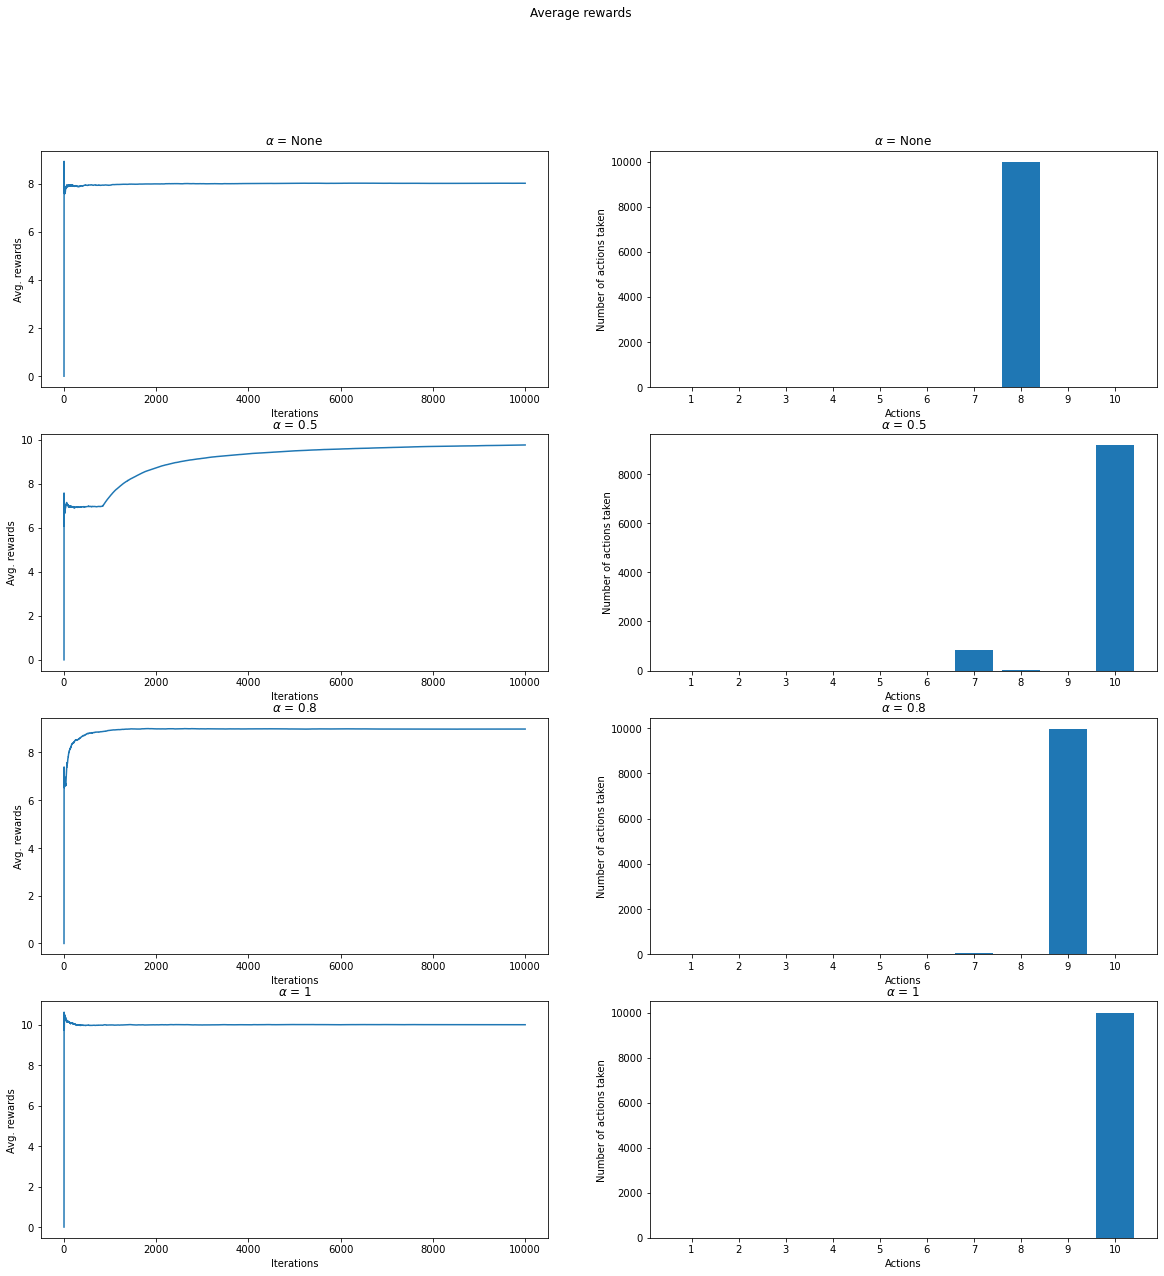

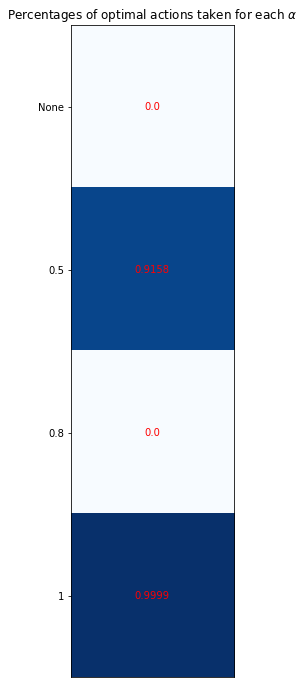

In [3]:
# Simulation parameters (some MUST be floats!).
iters = 10000
arms = 10
means = list(range(1, arms+1))
#means = np.full(arms, 0)
sigmas = np.full(arms, 1)
alphas = [None, 0.5, 0.8, 1]
det = False
stat = True

# Simulation data arrays.
rews = np.zeros((len(alphas), iters + 1))
actions = np.zeros((len(alphas), arms))
optimals = np.zeros((len(alphas), 1))

# Bandits execution.
for i in range(len(alphas)):
    bandit = PrefBandit(means, sigmas, iters=iters, alpha=alphas[i], deterministic=det, stationary=stat)
    bandit.run()
    rews[i, :] = bandit.get_avg_rewards()
    actions[i, :] = bandit.get_actions()
    optimals[i, 0] = bandit.get_opt_actions()

fig, ax = plt.subplots(len(alphas), 2, figsize=(20, 20))
fig.suptitle('Average rewards')
for i in range(len(alphas)):
    # Average rewards subplots.
    ax[i, 0].plot(rews[i, :])
    ax[i, 0].set(xlabel='Iterations', ylabel='Avg. rewards')
    ax[i, 0].set_title(r'$\alpha$ = ' + str(alphas[i]))
    # Actions taken subplots.
    x = np.arange(arms)
    ax[i, 1].bar(x, actions[i, :])
    ax[i, 1].set_xticks(x)
    ax[i, 1].set_xticklabels(np.arange(1, arms+1))
    ax[i, 1].set(xlabel='Actions', ylabel='Number of actions taken')
    ax[i, 1].set_title(r'$\alpha$ = ' + str(alphas[i]))

# Optimal actions frequency heatmap.
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(optimals, cmap='Blues')
ax.set_xticks([1.0])  # Don't ask.
ax.set_yticks(np.arange(len(alphas)))
ax.set_yticklabels(map(str, alphas))
ax.set_title(r'Percentages of optimal actions taken for each $\alpha$')
for i in range(len(alphas)):
    text = ax.text(0, i, optimals[i, 0], ha="center", va="center", color='r')